In [2]:
import scipy.stats
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xarray as xr
import tqdm
import os
import pickle
from tqdm.notebook import tqdm


## set plotting style
sns.set()

# ## initialize random number generator
# rng = np.random.default_rng()

path = "/glade/work/alancelin/EVT_rossbypalooza/"
os.chdir(path)

from src.evt import *

## Compute training and validation data

In [2]:
from pydrive.auth import GoogleAuth, ServiceAccountCredentials
from pydrive.drive import GoogleDrive

# Step 1: Load client secrets
gauth = GoogleAuth()
gauth.LoadClientConfigFile('/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/client_secret.json')  # Use your downloaded JSON file

# Step 2: Handle manual authentication
gauth.CommandLineAuth()  # Opens a URL in the terminal for manual authentication

# Step 3: Create GoogleDrive instance
drive = GoogleDrive(gauth)
drive

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=673680778613-r3bb6gp4og90odjgmbdtndinntc224nq.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [3]:
# Step 4: Define the folder ID
folder_id = '1zXUQmBBQWTJ796bgdi_ZgbV3Lnwfn2tk'

# Step 5: List the files in the specified folder
folder_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
folder_list_names = [file['title'] for file in folder_list]
# for file in folder_list:
#     print(f'title: {file["title"]}, id: {file["id"]}')

# for each folder 'sim0', print the files
for file in folder_list:
    if file['title'] == 'sim0':
        sim0_id = file['id']
        sim0_file_list = drive.ListFile({'q': f"'{sim0_id}' in parents and trashed=false"}).GetList()
        # for sim0_file in sim0_file_list:
        #     print(f'title: {sim0_file["title"]}, id: {sim0_file["id"]}')

# in that folder 'sim0', read the file 'tas_lat.46_lon.6_spatial.2_reduce.min.csv' using pandas
for file in sim0_file_list:
    if file['title'] == 'tas_lat.46_lon.6_spatial.2_reduce.mean.csv':
        file.GetContentFile('tas_lat.46_lon.6_spatial.2_reduce.mean.csv')
        df_train_val = pd.read_csv('tas_lat.46_lon.6_spatial.2_reduce.mean.csv', index_col=0)

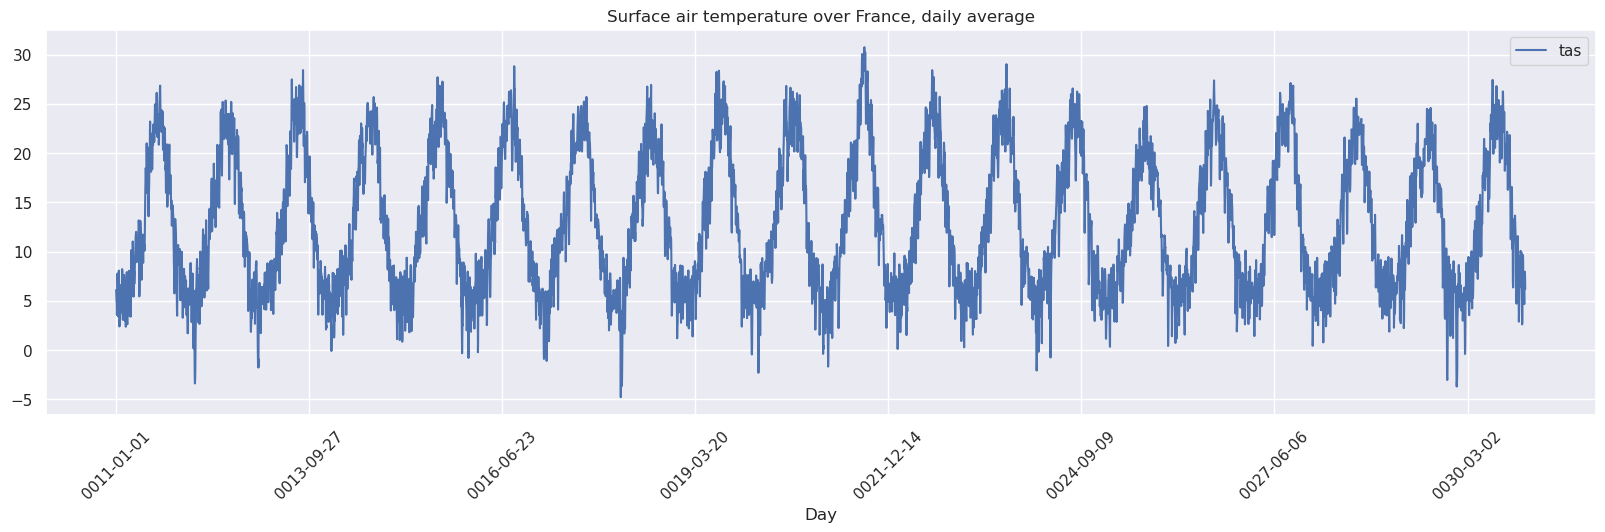

In [4]:
fig, ax = plt.subplots(figsize=(20, 5))
# print time series of df for the first 10 years
(df_train_val - 273.15).iloc[:20*365].plot(ax=ax)
# change orientation of x-axis labels
plt.xticks(rotation=45)
# add title
plt.title('Surface air temperature over France, daily average')
plt.show()

In [5]:
def preprocess(df, T=7):
    # convert the index to pandas.period
    df.index = pd.PeriodIndex(df.index, freq='D')
    # convert the temperature to celsius
    df = df - 273.15
    # compute the T-day rolling mean
    df = df.rolling(T).mean()
    # take the minimum of each year (Block Maxima approach)
    df = df.groupby(df.index.year).min()
    # change day to year
    df.index.name = 'Year'
    return df

In [6]:
T=7
A_train_val = preprocess(df_train_val, T=T)
# save the preprocessed data
A_train_val.to_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_train_val_T{T}.csv')

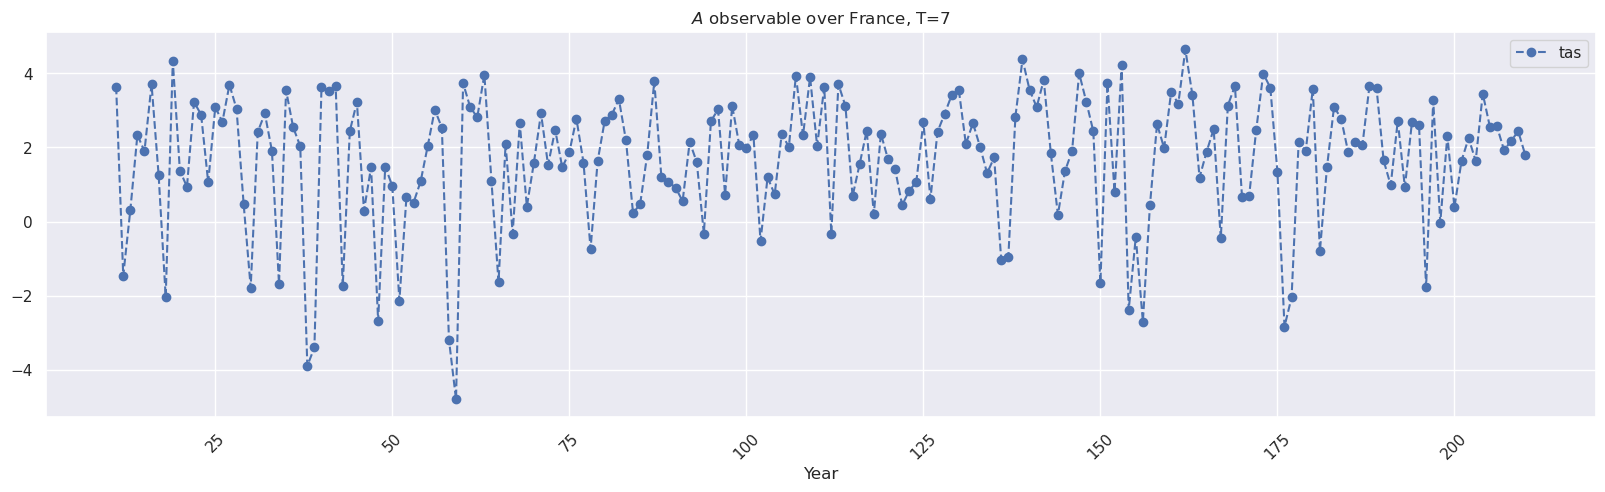

In [7]:
fig, ax = plt.subplots(figsize=(20, 5))
# print time series of df for the first 10 years (scatter plot)
(A_train_val).iloc[:200].plot(ax=ax, marker='o', linestyle='--')
# change orientation of x-axis labels
plt.xticks(rotation=45)
# add title
plt.title(r'$A$'+ f' observable over France, T={T}')
plt.show()

## Compute test data (long ground truth)

In [28]:
# for every folder in folder_list, read the file 'tas_lat.46_lon.6_spatial.2_reduce.min.csv' using pandas and finally concatenate all the dataframes
dfs = []

def produce_A_ground_truth(folder_list, T=7):
    for file in tqdm(folder_list):
        sim0_id = file['id']
        if file['title'] == 'sim0':
            # skip the folder 'sim0'
            continue
        sim0_file_list = drive.ListFile({'q': f"'{sim0_id}' in parents and trashed=false"}).GetList()
        for sim0_file in sim0_file_list:
            if sim0_file['title'] == 'tas_lat.46_lon.6_spatial.2_reduce.mean.csv':
                sim0_file.GetContentFile('tas_lat.46_lon.6_spatial.2_reduce.mean.csv')
                dfs.append(preprocess(pd.read_csv('tas_lat.46_lon.6_spatial.2_reduce.mean.csv', index_col=0), T=T))
    return pd.concat(dfs, axis=0, ignore_index=True)

A_test = produce_A_ground_truth(folder_list, T=T)
A_test.to_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_test_T{T}.csv')

  0%|          | 0/44 [00:00<?, ?it/s]

In [8]:
A_test = pd.read_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_test_T{T}.csv', index_col=0)

## Full pipeline

In [14]:
# PARAMS 
T = 7
n_train = 55000
bounds = dict(c=[-5, 5], loc=[-5, 15], scale=[0, 10])

# Load data 
A_test = pd.read_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_test_T{T}.csv', index_col=0)
A_train_val = pd.read_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_train_val_T{T}.csv', index_col=0)

In [15]:
def split_train_val(data_train_val, n_train):
    """
    Split data into training and validation sets
    """
    ## split data
    data_train, data_val = data_train_val[:n_train], data_train_val[n_train:]
    return data_train, data_val

A_train, A_val = split_train_val(A_train_val, n_train=n_train)

X = - A_train.values.squeeze()
X_val = - A_val.values.squeeze()
X_test = - A_test.values.squeeze()

In [16]:
import importlib
import src.evt
importlib.reload(src.evt)
from src.evt import *

Number of bins not specified. Using square root rule. 45


  3%|▎         | 1/30 [00:00<00:14,  2.05it/s]/glade/u/apps/opt/conda/envs/npl/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2357: RuntimeWarning: overflow encountered in divide
  x = (x - loc) / scale
100%|██████████| 30/30 [00:10<00:00,  2.93it/s]


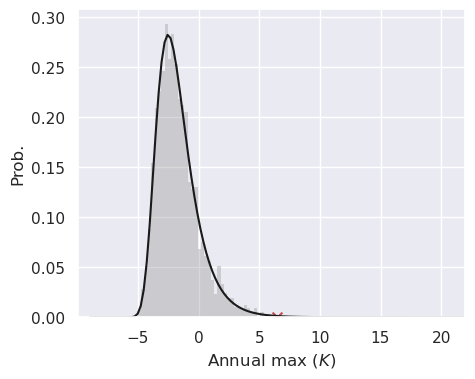

(-0.029046576599554546, -2.4911052931276645, 1.3035659572877305)


In [17]:
## specify model type, one of {"gev", "gp"}
model_type = "gev"

if model_type == "gev":
    model_class = scipy.stats.genextreme
    thresh = None

elif model_type == "gp":
    model_class = scipy.stats.genpareto
    thresh = 318

## Load data
# X = load_prepped_data(model_type=model_type, thresh=thresh)

## Empirical PDF (normalized histogram)
pdf_empirical, bin_edges = get_empirical_pdf(X)  #bin_edges = np.linspace(np.floor(X.min()), np.ceil(X.max()+20), np.sqrt(len(X)).astype(int)))

## Empirical return period
tr_empirical, Xr_empirical = get_empirical_return_period(X)

## Fit model and get return levels
model = fit_model(X, model_class, bounds)
Xr, tr = get_return_levels(model)

## Compute confidence interval
import datetime
format_date = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
bounds_fp = f"scripts/coldspells/bounds/{model_type}_T{T}_{format_date}_bounds.pkl"
Xr_lb, Xr_ub = load_return_period_bnds(
    X, model_class=model_class, n_samples=30, save_fp=bounds_fp, bounds=bounds
)
# Xr_lb, Xr_ub


## test points to plot curve
X_plot = np.linspace(X.min()-4, 40, 200)
## setup plot
fig, ax = plt.subplots(figsize=(5, 4))
## plot empirical pdf
ax.stairs(pdf_empirical, edges=bin_edges, color="gray", fill=True, alpha=0.3)
# plot distribution fit
ax.plot(X_plot, model.pdf(X_plot), c="k")
## plot max value
ax.scatter(X.max(), 0, marker="x", c="r", s=50)
## label
ax.set_xlabel(r"Annual max ($K$)")
ax.set_ylabel("Prob.")
ax.set_xlim(X.min()-5, 22)

plt.show()
print(model.args)

### Plot return level

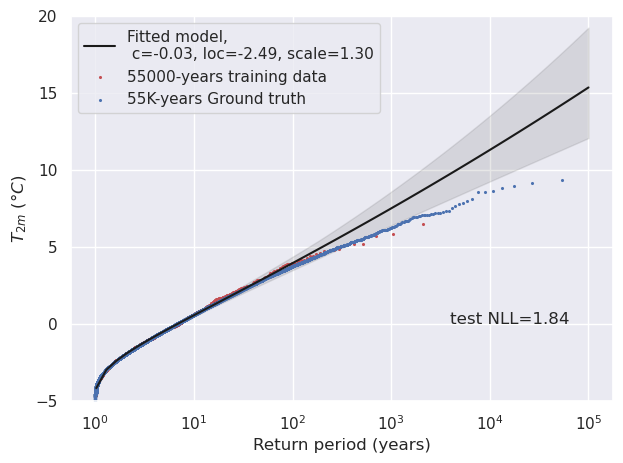

In [18]:
fig, ax = plt.subplots(figsize=(7, 5))

## plot modeled return period
ax.plot(tr, Xr, c="k", label=f"Fitted model, \n c={model.args[0]:.2f}, loc={model.args[1]:.2f}, scale={model.args[2]:.2f}")
ax.fill_between(tr, Xr_ub, Xr_lb, color="k", alpha=0.1)

## plot empirical return period
ax.scatter(tr_empirical, Xr_empirical, c="r", s=1.5, label=f"{n_train}-years training data")

## label axes
ax.set_xlabel("Return period (years)")
ax.set_ylabel(r"$T_{2m}$ ($°C$)")
ax.set_xscale("log")
ax.set_ylim(-5, 20)



# add the gound truth
t_test_r_empirical, X_test_r_empirical = get_empirical_return_period(X_test)
ax.scatter(t_test_r_empirical, X_test_r_empirical, c='b', s=1.5, label='55K-years Ground truth')

# # compute negative log likelihood on the test set
NLL_test = -model.logpdf(X_test).sum()/len(X_test)
# print it in the plot in the bottom right corner
ax.text(0.7, 0.2, f'test NLL={NLL_test:.2f}', transform=ax.transAxes)

plt.legend()
plt.show()

### Compare with what we get from pyextremes

In [30]:
series = pd.DataFrame(X)
# set the index of the series to be a datetime object
series['date'] = pd.date_range(start='1/1/1800', periods=len(series), freq='Y')
series.set_index('date', inplace=True)
series = series.rename(columns={0: 'T2m'})
series = series['T2m']
# from pandas import Timestamp
# series.index = Timestamp.to_pydatetime(series.index)

from pyextremes import EVA
model = EVA(series)

(<Figure size 768x480 with 1 Axes>, <Axes: xlabel='date', ylabel='T2m'>)

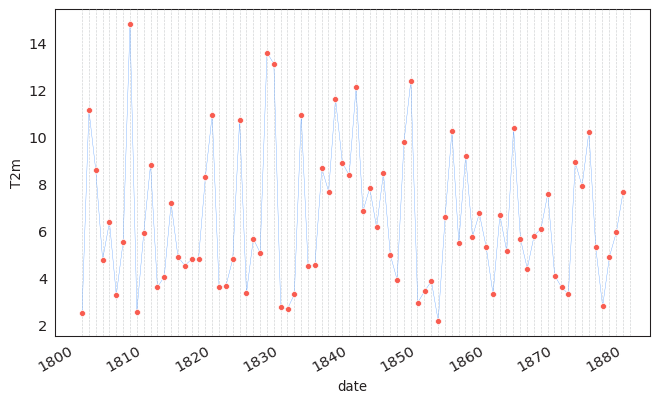

In [31]:
# # take annual maxima
# extremes = model.get_extremes(method="BM", block_size="365D")
extremes = model.set_extremes(extremes=series)
model.plot_extremes()

/glade/u/apps/opt/conda/envs/npl/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


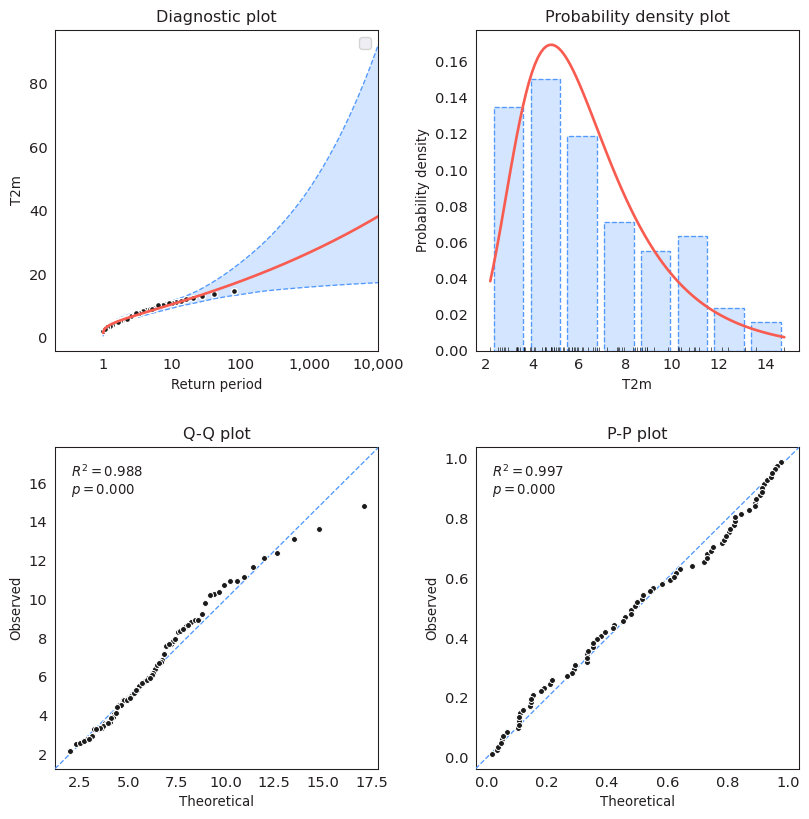

In [32]:
# fit model using generalized extreme value distribution
model.fit_model(distribution="genextreme")
fig, axs = model.plot_diagnostic(alpha=0.95, figsize=(10, 10), return_period=np.logspace(-1, 4, 1000))
axs[0].set_title("Diagnostic plot")
# plot a straight line at 319
# axs[0].axhline(y=319, color='r', linestyle='--')
axs[0].set_xlim(0.20, 10000)
# axs[0].scatter(return_periods, extreme_values_sorted, color='r', s=3, alpha=1, label="2000-years control run")
axs[0].legend()

In [ ]:
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                           T2m      Size:                                 300
Start:                      December 1800      End:                        December 2099
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                300      Extraction method:                     BM
Type:                                high      Block size:             365 days 00:00:00
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

## Use MC sampling to estimate return level

In [97]:
import importlib
import src.evt
importlib.reload(src.evt)
from src.evt import *

# PARAMS 
T = 7
n_train = 80
bounds = dict(c=[-5, 5], loc=[-5, 15], scale=[0.001, 10])

# Load data 
A_test = pd.read_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_test_T{T}.csv', index_col=0)
A_train_val = pd.read_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_train_val_T{T}.csv', index_col=0)

X = - A_train_val.values.squeeze()
X_test = - A_test.values.squeeze()

In [98]:
## Empirical return period
tr_empirical, Xr_empirical = get_empirical_return_period(X)

## Fit model and get return levels
model_type = "gev"
if model_type == "gev":
    model_class = scipy.stats.genextreme
    thresh = None
model = fit_model(X, model_class, bounds)
Xr, tr = get_return_levels(model)

## Compute confidence interval
import datetime
format_date = datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S")
bounds_fp = f"scripts/coldspells/bounds/MC/{model_type}_T{T}_c{bounds['c'][0]}.{bounds['c'][1]}_loc{bounds['loc'][0]}.{bounds['loc'][1]}_scale{bounds['scale'][0]}.{bounds['scale'][1]}_{format_date}_n{n_train}_bounds.pkl"

Xr_mean, Xr_median, Xr_lb, Xr_ub = load_return_period_bnds(
    X, model_class=model_class, n_samples=30, save_fp=bounds_fp, bounds=bounds, MC=True, n_train=n_train, n_mc=50)

100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


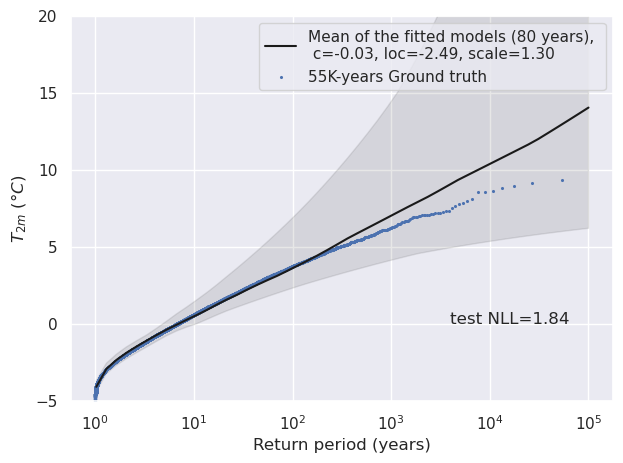

In [100]:
fig, ax = plt.subplots(figsize=(7, 5))

## plot modeled return period
ax.plot(tr, Xr_median, c="k", label=f"Mean of the fitted models ({n_train} years), \n c={model.args[0]:.2f}, loc={model.args[1]:.2f}, scale={model.args[2]:.2f}")
ax.fill_between(tr, Xr_ub, Xr_lb, color="k", alpha=0.1)

# ## plot empirical return period
# ax.scatter(tr_empirical, Xr_empirical, c="r", s=1.5, label=f"{n_train}-years training data")

## label axes
ax.set_xlabel("Return period (years)")
ax.set_ylabel(r"$T_{2m}$ ($°C$)")
ax.set_xscale("log")
ax.set_ylim(-5, 20)



# add the gound truth
t_test_r_empirical, X_test_r_empirical = get_empirical_return_period(X_test)
ax.scatter(t_test_r_empirical, X_test_r_empirical, c='b', s=1.5, label='55K-years Ground truth')

# # compute negative log likelihood on the test set
NLL_test = -model.logpdf(X_test).sum()/len(X_test)
# print it in the plot in the bottom right corner
ax.text(0.7, 0.2, f'test NLL={NLL_test:.2f}', transform=ax.transAxes)

plt.legend()
plt.show()

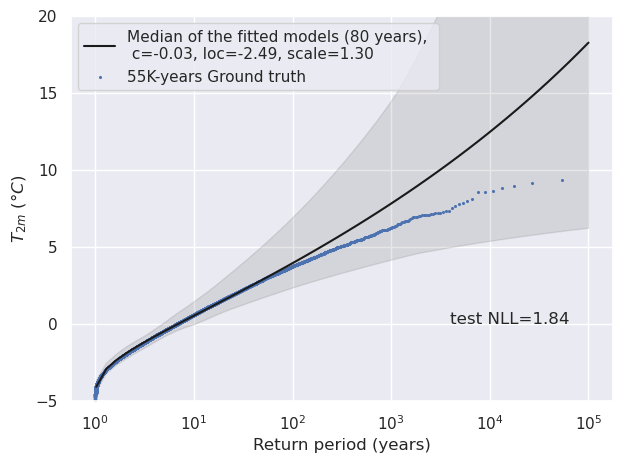

In [118]:
fig, ax = plt.subplots(figsize=(7, 5))

## plot modeled return period
ax.plot(tr, Xr_mean, c="k", label=f"Median of the fitted models ({n_train} years), \n c={model.args[0]:.2f}, loc={model.args[1]:.2f}, scale={model.args[2]:.2f}")
ax.fill_between(tr, Xr_ub, Xr_lb, color="k", alpha=0.1)

# ## plot empirical return period
# ax.scatter(tr_empirical, Xr_empirical, c="r", s=1.5, label=f"{n_train}-years training data")

## label axes
ax.set_xlabel("Return period (years)")
ax.set_ylabel(r"$T_{2m}$ ($°C$)")
ax.set_xscale("log")
ax.set_ylim(-5, 20)

# # put a minus in the y-axis values but keep the same direction
# ax.set_yticklabels([f"{-y if y !=0 else 0}" for y in ax.get_yticks()])

# add the gound truth
t_test_r_empirical, X_test_r_empirical = get_empirical_return_period(X_test)
ax.scatter(t_test_r_empirical, X_test_r_empirical, c='b', s=1.5, label='55K-years Ground truth')

# # compute negative log likelihood on the test set
NLL_test = -model.logpdf(X_test).sum()/len(X_test)
# print it in the plot in the bottom right corner
ax.text(0.7, 0.2, f'test NLL={NLL_test:.2f}', transform=ax.transAxes)

plt.legend()
plt.show()

# Compute boxplots

In [89]:
def get_target_return_value(X_test, target_return_period):
    """Interpolate the return value at a target return period with the 
    empirical return periods of the whole ground truth"""
    
    t_test_r_empirical, X_test_r_empirical = get_empirical_return_period(X_test)

    index_target_rv = np.argmin(np.abs(t_test_r_empirical - target_return_period))
    if t_test_r_empirical[index_target_rv] < target_return_period:
        index_target_rv += 1
    target_rv = np.mean(X_test_r_empirical[index_target_rv-1:index_target_rv+1])
    return target_rv, index_target_rv

get_target_return_value(X_test, 1000)

(6.215210714285693, 53268)

In [88]:
# compute the negative log likelihood on the test set
def compute_MC_return_value(full_data, model_class, bounds, n_train=80, n_mc=10, return_periods=100):
    """Compute the return value at a target return period using Monte Carlo simulation
    """
    ## empty list to hold result
    return_levels_samples = []
    for i in tqdm(range(n_mc)):
        # split data into training and testing
        train_data = draw_sample(full_data, n_train)
        # fit model on
        model = fit_model(train_data, model_class=model_class, bounds=bounds)
        # compute return period
        return_levels_samples.append(get_return_levels(model, return_periods=return_periods)[0])

    ## convert to array and compute bounds
    return_levels_samples = np.stack(return_levels_samples, axis=0)
    return return_levels_samples

In [147]:
n_train_list = [40, 80, 160, 320, 640, 1280, 5000, 10000]
n_mc = 50
# n_train_list = [320,  1280]
# n_mc = 10
target_return_period = 1000
bounds = dict(c=[-5, 5], loc=[-5, 15], scale=[0.001, 10])

target_return_value = get_target_return_value(X_test, target_return_period)[0]

medians = []
first_quartiles = []
third_quartiles = []
Xr_samples_list = []

for n_train in tqdm(n_train_list):
    Xr_samples = compute_MC_return_value(X_test, model_class, bounds, n_train=n_train, n_mc=n_mc, return_periods=target_return_period)
    Xr_samples_list.append(Xr_samples)

Xr_samples_list = np.stack(Xr_samples_list, axis=0)

 25%|██▌       | 2/8 [00:30<01:30, 15.16s/it]/glade/u/apps/opt/conda/envs/npl/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:3071: RuntimeWarning: overflow encountered in exp
  pex2 = np.exp(logpex2)
100%|██████████| 8/8 [02:52<00:00, 21.56s/it]


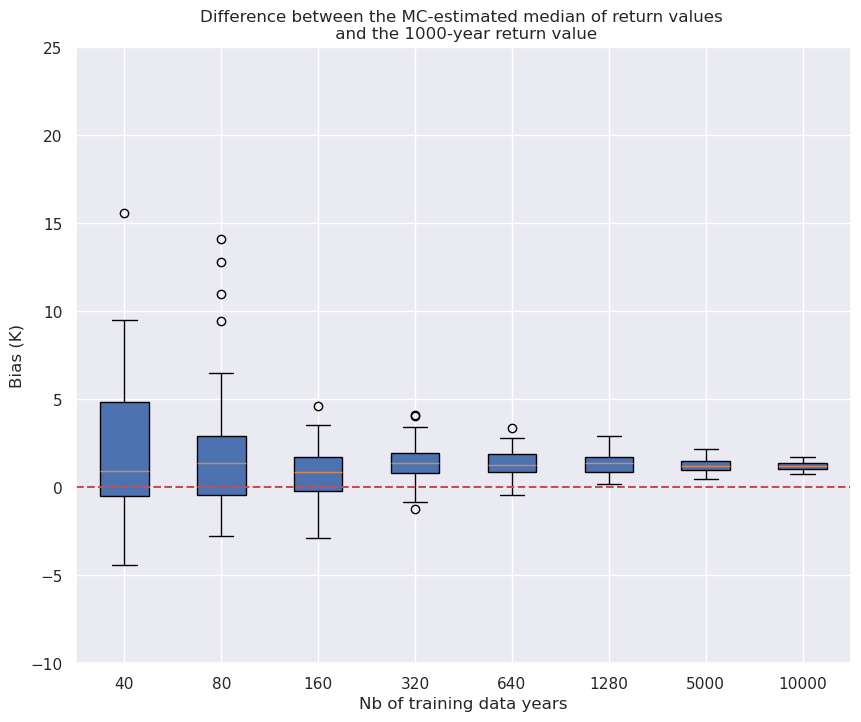

In [148]:
# Create the box plot
fig, ax = plt.subplots(figsize=(10, 8))

data = (-target_return_value + Xr_samples_list).T
plt.boxplot(data, vert=True, patch_artist=True, labels=n_train_list)  # will be used to label x-ticks

# Add title and labels
plt.title('Box plot of n_values')
plt.xlabel('Nb of training data years')
plt.ylabel('Bias (K)')
plt.title(f'Difference between the MC-estimated median of return values \n and the {target_return_period}-year return value')
# plot a straight line at 0
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(-10, 25)

# Show the plot
plt.show()

In [149]:
np.median(data, axis=0)

array([0.94862473, 1.35983894, 0.84546415, 1.38259682, 1.26808393,
       1.39258698, 1.21758759, 1.18444845])

In [150]:
x1, y1 = -0.8331145915361508, 48390.883727671295
x2, y2 = 3.9526642750896843, 58576.76002753723
# compute the slope and intercept
slope = (y2 - y1) / (x2 - x1)
intercept = y1 - slope * x1
slope, intercept

(2128.3633414193637, 50164.05428349841)

In [151]:
# the slope the define the total french electricity demand in MWh
number_of_hours = 24*T
# compute the total electricity consumption in MW over the period for each value in np.median(data, axis=0)
total_electricity_consumption = np.abs(slope * np.median(data, axis=0) * number_of_hours)
# compute the total electricity consumption in GWh over the period for each value in np.median(data, axis=0)
total_electricity_consumption = total_electricity_consumption/1000
total_electricity_consumption

array([339.1950415 , 486.23086747, 302.30842263, 494.36828949,
       453.4224831 , 497.94042054, 435.36675578, 423.51735942])

France has several nuclear power plants, and their capacity typically ranges from about 900 MW to 1,450 MW per reactor.
- For example, the Gravelines Nuclear Power Plant has a total capacity of about 5,460 MW (six reactors of 910 MW each).
- If we consider a plant with a capacity of 1,000 MW operating at full capacity for one year, the energy produced would be  1,000 \text{ MW} \times 24 \text{ hours/day} \times 365 \text{ days/year} \times 10^{-3} \text{ GWh/MW} = 8,760 \text{ GWh/year} .

To calculate the energy production of a power plant with a capacity of 1,000 MW operating at full capacity for one week, you can use the following formula:

\[ \text{Energy (GWh)} = \text{Power (MW)} \times \text{Time (hours)} \times 10^{-3} \]

First, calculate the number of hours in one week:

\[ 1 \text{ week} = 7 \text{ days} \times 24 \text{ hours/day} = 168 \text{ hours} \]

Now, use the formula to calculate the energy production:

\[ \text{Energy (GWh)} = 1,000 \text{ MW} \times 168 \text{ hours} \times 10^{-3} = 168 \text{ GWh} \]

So, a power plant with a capacity of 1,000 MW would produce 168 GWh of energy in one week if it operates at full capacity.

In [152]:
# convert total_electricity_consumption to unit of 168 GWh 
total_electricity_consumption/168 

array([2.0190181 , 2.89423135, 1.7994549 , 2.94266839, 2.69894335,
       2.96393107, 2.59146878, 2.52093666])

In [124]:
n_train_list = [40, 80, 160, 320, 640, 1280, 10000]
n_mc = 50
# n_train_list = [320,  1280]
# n_mc = 10
target_return_period = 10000
bounds = dict(c=[-5, 5], loc=[-5, 15], scale=[0.001, 10])

target_return_value = get_target_return_value(X_test, target_return_period)[0]

medians = []
first_quartiles = []
third_quartiles = []
Xr_samples_list = []

for n_train in tqdm(n_train_list):
    Xr_samples = compute_MC_return_value(X_test, model_class, bounds, n_train=n_train, n_mc=n_mc, return_periods=target_return_period)
    Xr_samples_list.append(Xr_samples)

Xr_samples_list = np.stack(Xr_samples_list, axis=0)

 57%|█████▋    | 4/7 [00:50<00:39, 13.03s/it]/glade/u/apps/opt/conda/envs/npl/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:3071: RuntimeWarning: overflow encountered in exp
  pex2 = np.exp(logpex2)
100%|██████████| 7/7 [02:05<00:00, 17.89s/it]


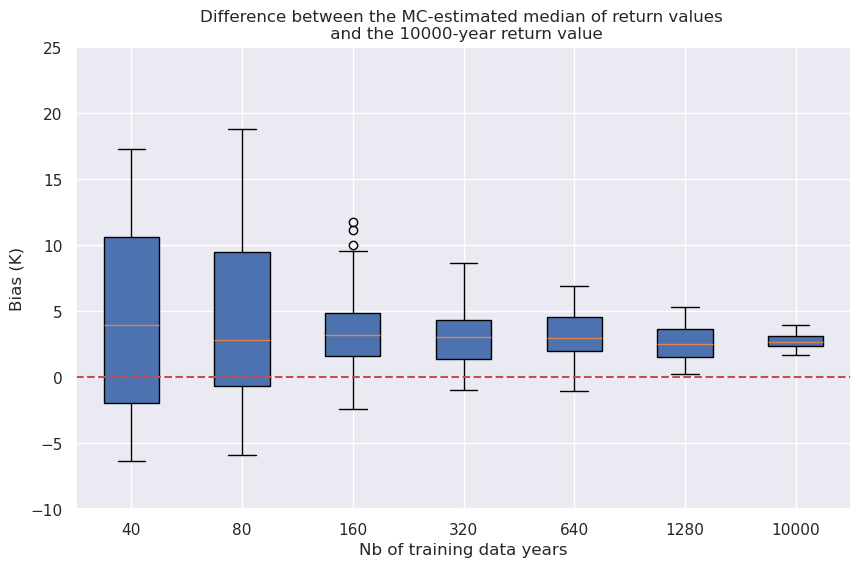

In [125]:
# Create the box plot
fig, ax = plt.subplots(figsize=(10, 6))

data = (-target_return_value + Xr_samples_list).T
plt.boxplot(data, vert=True, patch_artist=True, labels=n_train_list)  # will be used to label x-ticks

# Add title and labels
plt.title('Box plot of n_values')
plt.xlabel('Nb of training data years')
plt.ylabel('Bias (K)')
plt.title(f'Difference between the MC-estimated median of return values \n and the {target_return_period}-year return value')
# plot a straight line at 0
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(-10, 25)

# Show the plot
plt.show()

In [126]:
np.median(data, axis=0)

array([3.97255079, 2.79575616, 3.20159535, 3.02375455, 2.93591142,
       2.54293906, 2.68057608])